# Visualizing Var Rename Activations

In [1]:
import torch
import matplotlib.pyplot as plt

from iluvattnshun.utils import load_checkpoint, load_config_from_yaml
from iluvattnshun.nn import MultilayerTransformer

from var_rename import VariableRenamingConfig, VariableRenamingPrompter, VariableRenamingTrainer

/home/michael-lutz/miniconda3/envs/ila/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
2025-06-17 06:39:38.130990: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-06-17 06:39:38.145339: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1750142378.162887 2122885 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1750142378.168367 2122885 cuda_blas.

In [2]:
config_path = "/home/michael-lutz/iluvattnshun/logs/var_rename/run_104_sweep_6/config.yaml"
ckpt_path = "/home/michael-lutz/iluvattnshun/logs/var_rename/run_104_sweep_6/ckpt_epoch_973.pt"

In [3]:
config = load_config_from_yaml("/home/michael-lutz/iluvattnshun/logs/var_rename/run_104_sweep_6/config.yaml", VariableRenamingConfig)

# loading the model
max_seq_len = config.chain_length * config.num_chains * 4 + 2
model = MultilayerTransformer(
	vocab_size=39,
	d_model=config.dim_model,
	n_heads=config.num_heads,
	n_layers=config.num_layers,
	max_seq_len=max_seq_len,
)
load_checkpoint(ckpt_path, model, None, "cuda")

# loading the prompter
prompter = VariableRenamingPrompter(config)

In [6]:
# printing out the prompt, pred (per token), and true answer
prompt, answer = prompter.get_prompt()
x = torch.tensor(prompter.tokenize(prompt)).unsqueeze(0)
logits, attn_weights, _= model.forward(x, return_attn_weights=True)
pred = prompter.detokenize(logits[0].argmax(dim=-1).tolist())

print("prompt: ", prompt)
print("pred:   ", pred)
print("answer: ", answer)


prompt:  6>j;8>f;f>z;z>n;n>o;j>m;m>f;f>a;o?
pred:    6666888699687208868806465964568688
answer:  8


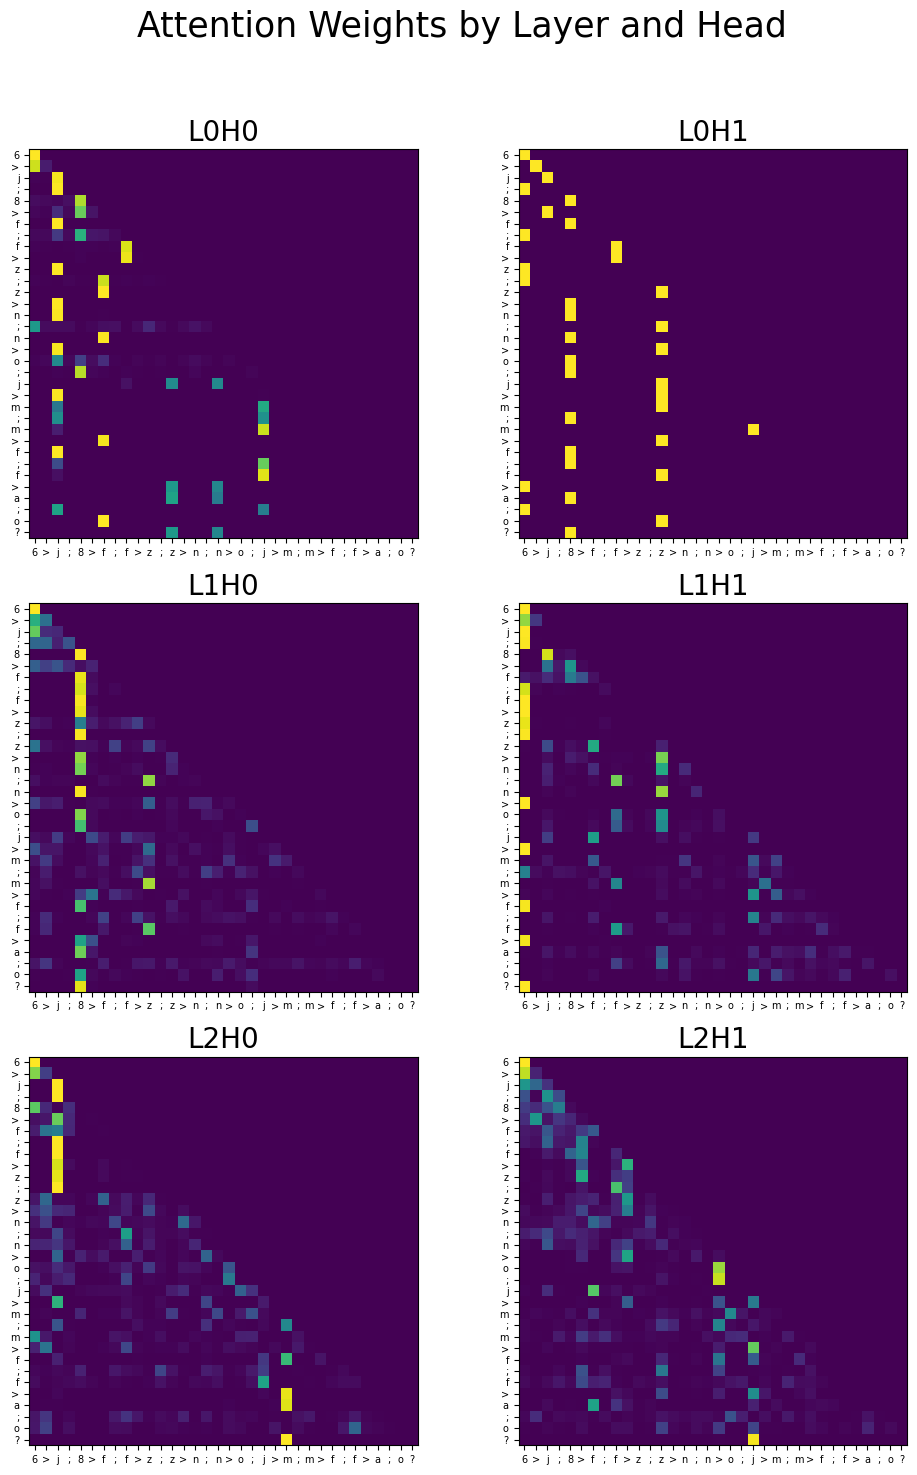

In [ ]:
# plot attention weights over layers and heads

token_labels = list(prompt)
num_layers = len(attn_weights)
num_heads = config.num_heads
total_heads = num_layers * num_heads

rows = num_layers
cols = num_heads
fig, axes = plt.subplots(rows, cols, figsize=(cols * 5, rows * 5), squeeze=False)

head_idx = 0
for layer_idx, attn_weight_heads in enumerate(attn_weights):
    for head_number in range(num_heads):
        row = head_idx // cols
        col = head_idx % cols
        ax = axes[row][col]

        attn_weight = attn_weight_heads[0, head_number].detach().cpu().numpy()
        im = ax.imshow(attn_weight, cmap="viridis")

        ax.set_title(f"L{layer_idx}H{head_number}", fontsize=20)

        ax.set_xticks(range(len(token_labels)))
        ax.set_xticklabels(token_labels, fontsize=7)
        ax.set_yticks(range(len(token_labels)))
        ax.set_yticklabels(token_labels, fontsize=7)

        head_idx += 1

# Hide any unused subplots
for i in range(head_idx, rows * cols):
    fig.delaxes(axes[i // cols][i % cols])

fig.suptitle("Attention Weights by Layer and Head", fontsize=25)
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()


In [48]:
model.generate(x[:, :-10], 10, 1.0)

tensor([[ 5, 36, 25, 38, 25, 36, 15, 38, 15, 36, 18, 38,  9, 36, 29, 38, 18, 36,
         31, 38, 29, 36, 15, 38,  5,  7,  9,  5,  4,  9,  5,  5,  7,  9]])